In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs,\
                                  pad_seqs_2step, pad_seqs_1step, calculate_output, onehot2seq 

from sklearn.metrics import r2_score
import math

# Functions

In [104]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        y = 1/math.sqrt(hidden_size)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.0001)


def train(sequence, label ,model ,optimizer ,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model

def change_padder(seqs, cue_dict, xval):
    """ changes value of X from zero to a new value
        and recalculates sequence output"""
    cue_dict['X'] = xval
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, cue_dict, bidmas = False))

    return inps, cue_dict

def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict, bidmas = False))

    return inps

def predcorr(mods, tests):
    dfs1 = []
    for i in range(len(mods)):
        
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
        all_dfs1 = pd.concat(dfs1) 
        preds, labs = all_dfs1['pred'], all_dfs1['label']
        xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
        r2_val = r2_score(all_dfs1['pred'],all_dfs1['label'])
        
        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_val, 2)) )
        
        print(all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False))
    return r2_val, all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False) 

# -----------------
# Generating trials
# -----------------

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp,('+', 'X')]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
    return seq


def generate_trials(operators, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=1))
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            for op in combi_operators:
                seq.append([init,
                            *zip(tuple(op), cue)]) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict, False))
    return seq

def generate_self(operators, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(operators, inp, inp)
        seq += trial
    return seq

def generate_other_pairs(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i])]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
    return seq


# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

# RNN setup

In [23]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1000
num_sims = 8
num_inputs = 5

In [99]:
## running function

def run_exp(trainseqs_old, testseqs_old):

    all_syms = list(cue_dict.keys())[1:]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

def run_plot(trainseqs, testseqs):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, testseqs) for i in range(num_sims))
    t2 = time.time()
    print('time: ', (t2-t1)/60)

    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    tests = [r['test'] for r in res]

    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)
    
    plt.figure()
    r2, dfs = predcorr(mods, tests)
    
    return res, r2

# Trials

In [59]:
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {'X':0}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)

{'X': 0, 'A': 3, 'B': 4, 'C': 6, 'D': 14, 'E': 12}


# Experiments

1. 
2. 



In [107]:
ops = ['+']

In [108]:
# 1:
p = generate_primitives(all_syms)
trainseqs = generate_trials(ops, all_syms[1:], all_syms[1:]) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [t for t in testseqs if t not in trainseqs]


time:  0.6120755513509114
                 label       pred  acc
trial                                 
['A', '+', 'A']   18.0  18.418976  1.0
['A', '+', 'B']   24.0  24.035847  1.0
['A', '+', 'C']   25.0  25.049110  1.0
['A', '+', 'D']   15.0  15.043688  1.0
['A', '+', 'E']   21.0  21.038675  1.0
['B', '+', 'A']   24.0  24.475817  1.0
['C', '+', 'A']   25.0  25.480431  1.0
['D', '+', 'A']   15.0  15.451353  1.0
['E', '+', 'A']   21.0  21.446358  1.0
                 label       pred  acc
trial                                 
['A', '+', 'B']   22.5  22.549004  1.0
['A', '+', 'C']   23.5  23.555866  1.0
['A', '+', 'D']   17.0  17.061633  1.0
['A', '+', 'E']   20.5  20.558333  1.0
['A', '+', 'A']   25.0  22.172033  0.5
['B', '+', 'A']   22.5  19.662277  0.5
['C', '+', 'A']   23.5  20.657924  0.5
['D', '+', 'A']   17.0  14.146284  0.5
['E', '+', 'A']   20.5  17.651480  0.5
                     label       pred       acc
trial                                          
['A', '+', 'B']  19.

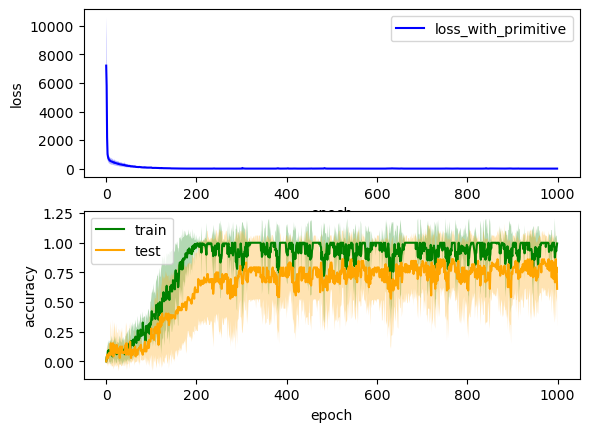

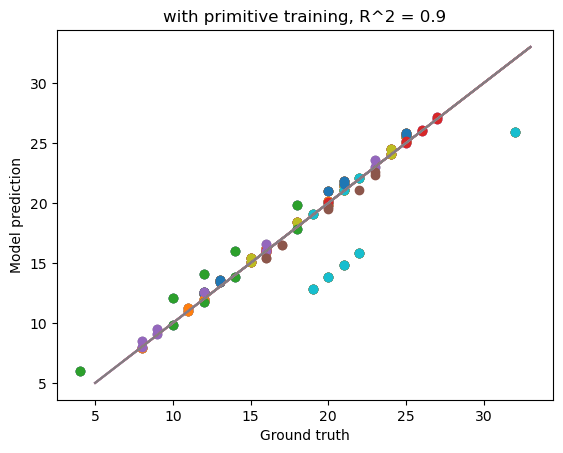

In [100]:
res1, r2_1 = run_plot(trainseqs, testseqs)

In [114]:
p = generate_primitives(all_syms)
trainseqs = generate_other_pairs(ops[0], all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [t for t in testseqs if t not in trainseqs]


time:  0.43500418265660606
                 label       pred  acc
trial                                 
['A', '+', 'A']   22.0  22.470448  1.0
['A', '+', 'C']   13.0  13.205919  1.0
['E', '+', 'D']   19.0  19.248087  1.0
['E', '+', 'C']    7.0   6.981550  1.0
['E', '+', 'B']   22.0  21.838554  1.0
['D', '+', 'D']   28.0  28.479179  1.0
['D', '+', 'C']   16.0  16.212643  1.0
['D', '+', 'B']   31.0  31.069647  1.0
['D', '+', 'A']   25.0  25.477169  1.0
['C', '+', 'E']    7.0   7.098426  1.0
['C', '+', 'C']    4.0   3.995377  1.0
['C', '+', 'B']   19.0  18.852385  1.0
['C', '+', 'A']   13.0  13.259904  1.0
['B', '+', 'E']   22.0  21.935389  1.0
['B', '+', 'D']   31.0  31.098875  1.0
['B', '+', 'B']   34.0  33.689342  1.0
['B', '+', 'A']   28.0  28.096865  1.0
['A', '+', 'E']   16.0  16.308969  1.0
['A', '+', 'D']   25.0  25.472456  1.0
['E', '+', 'E']   10.0  10.084599  1.0
                 label       pred  acc
trial                                 
['A', '+', 'A']   22.0  22.235688  1.

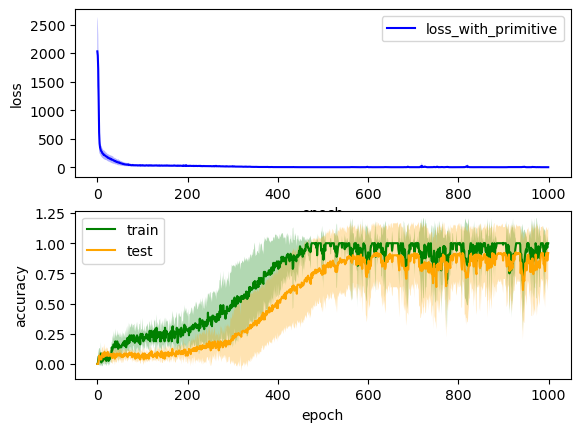

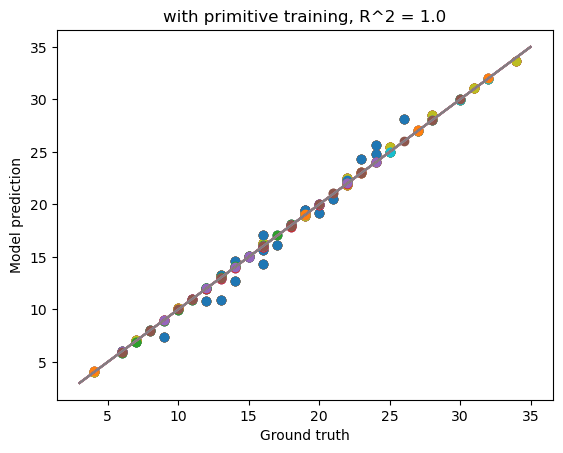

In [117]:
res1, r2_1 = run_plot(trainseqs, testseqs)

In [119]:
num_inputs = 4

total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {'X':0}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)

{'X': 0, 'A': 15, 'B': 17, 'C': 9, 'D': 2}
